In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler

print("Toutes les bibliothèques importées avec succès!")

Toutes les bibliothèques importées avec succès!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def analyze_images(path):
    valid_exts = ('.jpeg', '.jpg', '.png')

    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(path, subset)
        if not os.path.exists(subset_path):
            print(f"⚠️ Dossier {subset} introuvable !")
            continue

        print(f"\n--- {subset.upper()} ---")
        for category in ['NORMAL', 'PNEUMONIA']:
            category_path = os.path.join(subset_path, category)
            if not os.path.exists(category_path):
                print(f"⚠️ Dossier {category} introuvable dans {subset}!")
                continue

            widths, heights = [], []
            for fname in os.listdir(category_path):
                if fname.lower().endswith(valid_exts):
                    img_path = os.path.join(category_path, fname)
                    try:
                        with Image.open(img_path) as img:
                            w, h = img.size
                            widths.append(w)
                            heights.append(h)
                    except Exception as e:
                        print(f"Erreur avec {img_path}: {e}")

            print(f"{category}: {len(widths)} images")
            if widths and heights:
                print(f"   Smallest: {min(widths)}x{min(heights)}")
                print(f"   Biggest:  {max(widths)}x{max(heights)}")
                print(f"   Average:  {np.mean(widths):.1f}x{np.mean(heights):.1f}")
            else:
                print("   Aucune image trouvée !")

# Appel de la fonction
data_dir = '/content/drive/MyDrive/chest_xray'
analyze_images(data_dir)


--- TRAIN ---
NORMAL: 1341 images
   Smallest: 912x672
   Biggest:  2916x2663
   Average:  1667.7x1381.4
PNEUMONIA: 3875 images
   Smallest: 384x127
   Biggest:  2772x2304
   Average:  1200.5x825.0

--- VAL ---
NORMAL: 8 images
   Smallest: 1240x928
   Biggest:  1776x1416
   Average:  1479.5x1191.9
PNEUMONIA: 8 images
   Smallest: 968x592
   Biggest:  1664x1128
   Average:  1217.0x814.0

--- TEST ---
NORMAL: 234 images
   Smallest: 984x496
   Biggest:  2752x2713
   Average:  1800.3x1369.1
PNEUMONIA: 390 images
   Smallest: 728x344
   Biggest:  2000x1456
   Average:  1140.8x765.3


Size: (1562, 1021)
Mode: L
Format: JPEG


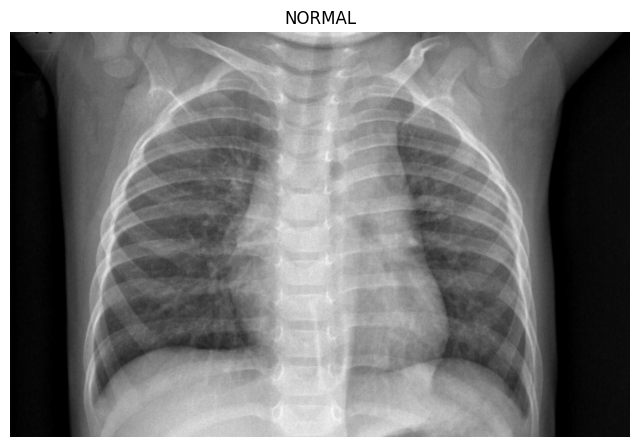

In [7]:
def show_a_sample(path):
    with Image.open(path) as img:
        print(f"Size: {img.size}")
        print(f"Mode: {img.mode}")
        print(f"Format: {img.format}")

        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.title('NORMAL' if 'NORMAL' in path else 'PNEUMONIA')
        plt.show()

show_a_sample('/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0065-0001.jpeg')

In [8]:
def configure_for_performance():
    # Optimisation CUDA si disponible
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        print("CUDA optimizations enabled")

    # Nettoyage du cache GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Configuration des workers pour le data loading
    num_workers = min(8, multiprocessing.cpu_count())
    print(f"Number of workers: {num_workers}")
    return num_workers

# Setup mixed precision
def setup_mixed_precision():
    scaler = GradScaler()
    return scaler

# Appel de la configuration
num_workers = configure_for_performance()
scaler = setup_mixed_precision()
print("Optimisations de performance configurées!")

CUDA optimizations enabled
Number of workers: 2
Optimisations de performance configurées!


/tmp/ipython-input-1254889812.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [9]:
# Transformation des données avec augmentation avancée
advanced_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Charger les datasets avec les nouvelles transformations
advanced_datasets = {
    x: ImageFolder(os.path.join(data_dir, x), advanced_transforms[x])
    for x in ['train', 'val', 'test']
}

# Gestion du déséquilibre des classes
class_counts = [advanced_datasets['train'].targets.count(i) for i in range(2)]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
print(f"Distribution des classes: {class_counts}")
print(f"Poids des classes: {class_weights}")

# Créer un sampler pour gérer le déséquilibre
weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=class_weights[advanced_datasets['train'].targets],
    num_samples=len(advanced_datasets['train']),
    replacement=True
)

advanced_dataloaders = {
    'train': DataLoader(advanced_datasets['train'], batch_size=32,
                       sampler=weighted_sampler, num_workers=num_workers, pin_memory=True),
    'val': DataLoader(advanced_datasets['val'], batch_size=32,
                     shuffle=False, num_workers=num_workers, pin_memory=True),
    'test': DataLoader(advanced_datasets['test'], batch_size=32,
                      shuffle=False, num_workers=num_workers, pin_memory=True)
}

dataset_sizes = {x: len(advanced_datasets[x]) for x in ['train', 'val', 'test']}
class_names = advanced_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Nombre d'images: {dataset_sizes}")
print("Transformations et dataloaders créés avec succès!")

Distribution des classes: [1341, 3875]
Poids des classes: tensor([0.0007, 0.0003])
Classes: ['NORMAL', 'PNEUMONIA']
Nombre d'images: {'train': 5216, 'val': 16, 'test': 624}
Transformations et dataloaders créés avec succès!


In [10]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Sauvegarde le modèle quand la loss de validation diminue.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

print("Early Stopping défini!")

Early Stopping défini!


In [11]:
def create_optimized_model(learning_rate=0.001, fine_tune_layers=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Charger ResNet50 pré-entraîné
    model = models.resnet50(pretrained=True)

    # Fine-tuning progressif
    layers_to_unfreeze = list(model.children())[-fine_tune_layers:]
    for layer in layers_to_unfreeze:
        for param in layer.parameters():
            param.requires_grad = True

    # Classificateur personnalisé
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.1),
        nn.Linear(256, 2)
    )

    model = model.to(device)

    # Optimiseur avec weight decay
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=1e-4
    )

    # Scheduler avec warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=20,
        steps_per_epoch=len(advanced_dataloaders['train'])
    )

    # Loss avec poids des classes
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    return model, optimizer, scheduler, criterion, device

# Création du modèle optimisé
optimized_model, optimizer, scheduler, criterion, device = create_optimized_model()
print("Modèle optimisé créé avec succès!")
print(f"Device utilisé: {device}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


Modèle optimisé créé avec succès!
Device utilisé: cuda:0


In [12]:
def advanced_train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    early_stopping = EarlyStopping(patience=10, verbose=True, path='best_model_advanced.pth')
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in advanced_dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixed precision pour l'entraînement
                    if phase == 'train':
                        with autocast():
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(advanced_datasets[phase])
            epoch_acc = running_corrects.double() / len(advanced_datasets[phase])

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().numpy())
                current_lr = optimizer.param_groups[0]['lr']
                print(f'Learning Rate: {current_lr:.6f}')
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().numpy())

                # Early stopping
                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping triggered!")
                    return model, train_losses, val_losses, train_accs, val_accs

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model, train_losses, val_losses, train_accs, val_accs

# Entraînement avec toutes les optimisations
print("Début de l'entraînement optimisé...")
optimized_model, train_losses, val_losses, train_accs, val_accs = advanced_train_model(
    optimized_model, criterion, optimizer, scheduler, num_epochs=30
)

Début de l'entraînement optimisé...
Epoch 1/30
----------


/tmp/ipython-input-2613303655.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Learning Rate: 0.000104
Train Loss: 0.2074 Acc: 0.8988
Validation loss decreased (inf --> 0.227782). Saving model...
Val Loss: 0.2278 Acc: 0.6875

Epoch 2/30
----------
Learning Rate: 0.000280
Train Loss: 0.1147 Acc: 0.9410
Validation loss decreased (0.227782 --> 0.105402). Saving model...
Val Loss: 0.1054 Acc: 0.9375

Epoch 3/30
----------
Learning Rate: 0.000521
Train Loss: 0.1190 Acc: 0.9410
EarlyStopping counter: 1 out of 10
Val Loss: 0.2072 Acc: 0.8750

Epoch 4/30
----------
Learning Rate: 0.000761
Train Loss: 0.1111 Acc: 0.9456
EarlyStopping counter: 2 out of 10
Val Loss: 0.2707 Acc: 0.8750

Epoch 5/30
----------
Learning Rate: 0.000936
Train Loss: 0.1449 Acc: 0.9247
EarlyStopping counter: 3 out of 10
Val Loss: 0.3978 Acc: 0.7500

Epoch 6/30
----------
Learning Rate: 0.001000
Train Loss: 0.1005 Acc: 0.9511
EarlyStopping counter: 4 out of 10
Val Loss: 0.4839 Acc: 0.6875

Epoch 7/30
----------
Learning Rate: 0.000987
Train Loss: 0.1168 Acc: 0.9425
EarlyStopping counter: 5 out of 10

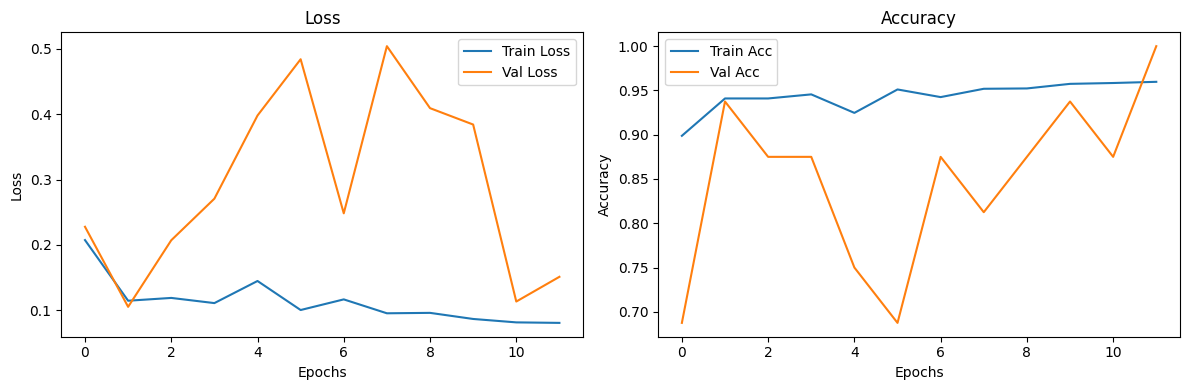

Courbes d'apprentissage générées!


In [13]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

print("Courbes d'apprentissage générées!")

In [14]:
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in advanced_dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Rapport de classification:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\nMatrice de confusion:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    return all_preds, all_labels

# Charger le meilleur modèle
optimized_model.load_state_dict(torch.load('best_model_advanced.pth'))
print("Meilleur modèle chargé!")

# Évaluation
all_preds, all_labels = evaluate_model(optimized_model)

Meilleur modèle chargé!
Rapport de classification:
              precision    recall  f1-score   support

      NORMAL       0.93      0.86      0.89       234
   PNEUMONIA       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624


Matrice de confusion:
[[201  33]
 [ 15 375]]


In [15]:
# Sauvegarde du modèle final
torch.save({
    'model_state_dict': optimized_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'class_names': class_names,
    'transforms': advanced_transforms
}, 'pneumonia_classifier_complete.pth')

print("Modèle complet sauvegardé avec succès!")

# Sauvegarde supplémentaire du modèle seul pour l'inférence
torch.save(optimized_model.state_dict(), 'pneumonia_classifier_inference.pth')
print("Modèle d'inférence sauvegardé!")

# Information sur les fichiers sauvegardés
import os
file_sizes = {}
for file in ['best_model_advanced.pth', 'pneumonia_classifier_complete.pth', 'pneumonia_classifier_inference.pth']:
    if os.path.exists(file):
        size_mb = os.path.getsize(file) / (1024 * 1024)
        file_sizes[file] = size_mb
        print(f"{file}: {size_mb:.2f} MB")

print("\n✅ Tous les modèles ont été sauvegardés avec succès!")

Modèle complet sauvegardé avec succès!
Modèle d'inférence sauvegardé!
best_model_advanced.pth: 94.50 MB
pneumonia_classifier_complete.pth: 283.04 MB
pneumonia_classifier_inference.pth: 94.51 MB

✅ Tous les modèles ont été sauvegardés avec succès!


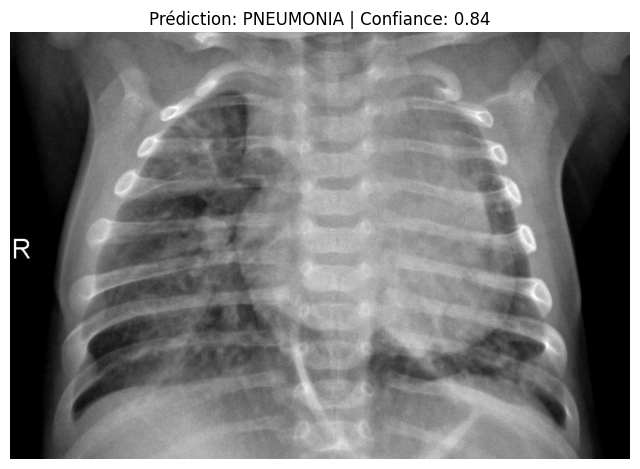

Résultat: PNEUMONIA avec 83.99% de confiance


In [16]:
def predict_image(image_path, model, transforms):
    model.eval()

    # Charger et transformer l'image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms(image).unsqueeze(0).to(device)

    # Prédiction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, prediction = torch.max(probabilities, 1)

    # Affichage
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Prédiction: {class_names[prediction]} | Confiance: {confidence.item():.2f}')
    plt.show()

    return class_names[prediction], confidence.item()

# Test avec une image
test_image_path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
prediction, confidence = predict_image(test_image_path, optimized_model, advanced_transforms['test'])
print(f"Résultat: {prediction} avec {confidence:.2%} de confiance")

In [17]:
def benchmark_model(model, dataloader, num_iterations=100):
    model.eval()
    device = next(model.parameters()).device

    # Warm up
    print("Warm up...")
    for i, (inputs, _) in enumerate(dataloader):
        if i >= 10:
            break
        inputs = inputs.to(device)
        with torch.no_grad():
            _ = model(inputs)

    # Benchmark
    print("Benchmarking...")
    start_time = time.time()

    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= num_iterations:
                break
            inputs = inputs.to(device)
            _ = model(inputs)

    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_batch = total_time / num_iterations
    avg_time_per_image = avg_time_per_batch / dataloader.batch_size

    print(f"Temps total pour {num_iterations} batches: {total_time:.2f}s")
    print(f"Temps moyen par batch: {avg_time_per_batch*1000:.2f}ms")
    print(f"Temps moyen par image: {avg_time_per_image*1000:.2f}ms")
    print(f"Images par seconde: {dataloader.batch_size/avg_time_per_batch:.2f}")

# Benchmark
print("Benchmark des performances:")
benchmark_model(optimized_model, advanced_dataloaders['test'])

Benchmark des performances:
Warm up...
Benchmarking...
Temps total pour 100 batches: 11.45s
Temps moyen par batch: 114.48ms
Temps moyen par image: 3.58ms
Images par seconde: 279.53
